In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ezc3d import c3d
from scipy.signal import resample
from scipy.io import loadmat, savemat
from scipy import sparse
from scipy.sparse.linalg import spsolve
from joblib import load, dump
from tqdm import tqdm
from scipy.signal import butter, lfilter, medfilt

# Constants

In [2]:
PATH_DATASETS = '../../Dataset/'
PATH_DATASET_2 = 'gait-dbase-2/'

N_SAMPLES = 1024
FORCE_THRESHOLD = 20
TOE_HEIGTH_THRESHOLD = 40

# Filter

In [3]:
class LowPassFilter(object): 
    @staticmethod
    def butter_lowpass(cutoff, fs, order):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def apply(data, cutoff=6, fs=2000, order=2, axis=-1):
        b, a = LowPassFilter.butter_lowpass(cutoff, fs, order=order)
        y = lfilter(b, a, data, axis=axis)
        y = y - np.median(y)
        return y

# Function Defs

In [4]:
def standardize(x):
    # return (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))

def require_positive(x):
    if x < 0:
        return 0
    else:
        return x

def clip_overflow(x, max=N_SAMPLES):
    if x >= max:
        return N_SAMPLES - 1
    else:
        return x

def clip_noise(x, min=FORCE_THRESHOLD):
    mask = x > min
    new_x = np.zeros(x.shape)
    new_x[mask] = x[mask]
    return new_x

def get_first_grf(x, swing_period):
    half_way = x.shape[0] / 2
    temp = np.zeros(x.shape)
    temp[:half_way] = x[:half_way]
    stance_mask = temp < FORCE_THRESHOLD
    stance_start = np.min(stance_mask == True)
    stance_end = np.max(stance_mask == True)
    roi_start = stance_start
    roi_end = stance_end + swing_period
    return temp[roi_start : roi_end]

def get_processed_grf(grf, clip=False):
    processed_grf = LowPassFilter.apply(grf, fs=2000, cutoff=20)
    if clip:
        processed_grf[processed_grf < FORCE_THRESHOLD] = 0
    return resample(processed_grf, N_SAMPLES * 4, axis=0).T

def get_processed_moment(moment):
    processed_moment = LowPassFilter.apply(moment, fs=2000, cutoff=20)
    return resample(processed_moment, N_SAMPLES * 4, axis=0).T
    

In [5]:
# Use trajectories-z 6-9 for y-axis

def get_trajectories(content, foot='right'):
    if foot == 'right':
        trajectory_x = content['data']['points'][0, 12:24, :]
        trajectory_y = content['data']['points'][1, 12:24, :]
        trajectory_z = content['data']['points'][2, 12:24, :]

    elif foot == 'left':
        trajectory_x = content['data']['points'][0, 0:12, :]
        trajectory_y = content['data']['points'][1, 0:12, :]
        trajectory_z = content['data']['points'][2, 0:12, :]

    else:
        raise ValueError('Third foot is not allowed')

    # trajectory_x = LowPassFilter.apply(trajectory_x, fs=200, cutoff=20)
    # trajectory_y = LowPassFilter.apply(trajectory_y, fs=200, cutoff=20)
    # trajectory_z = LowPassFilter.apply(trajectory_z, fs=200, cutoff=20)

    trajectory_x = resample(trajectory_x, N_SAMPLES * 4, axis=1).T
    trajectory_y = resample(trajectory_y, N_SAMPLES * 4, axis=1).T
    trajectory_z = resample(trajectory_z, N_SAMPLES * 4, axis=1).T

    return trajectory_x, trajectory_y, trajectory_z

def get_force(content):
    force_x = []
    force_y = []
    force_z = []
    for i in range(1, 5):
        force_x.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][0, :]
            )
        )
        force_y.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][1, :]
            )
        )
        force_z.append(
            get_processed_grf(
                content['data']['platform'][i]['force'][2, :], True
            )
        )

    return force_x, force_y, force_z

def get_moment(content):
    moment_x = []
    moment_y = []
    moment_z = []
    for i in range(1, 5):
        moment_x.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][0, :]
            )
        )
        moment_y.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][1, :]
            )
        )
        moment_z.append(
            get_processed_moment(
                content['data']['platform'][i]['moment'][2, :]
            )
        )

    return moment_x, moment_y, moment_z

def get_swing_period(force_plate_data_z):
    grf_combined_z_r = force_plate_data_z[0] + force_plate_data_z[2]
    grf_combined_z_l = force_plate_data_z[1] + force_plate_data_z[3]

    grf_mask_r = (grf_combined_z_r >= FORCE_THRESHOLD)
    grf_mask_l = (grf_combined_z_l >= FORCE_THRESHOLD)

    grf_start_r = np.min(np.argwhere(grf_mask_r == True))
    grf_end_r = np.max(np.argwhere(grf_mask_r == True))
    grf_start_l = np.min(np.argwhere(grf_mask_l == True))
    grf_end_l = np.max(np.argwhere(grf_mask_l == True))

    swing_period_r = np.sum(grf_combined_z_r[grf_start_r:grf_end_r] <= FORCE_THRESHOLD)
    swing_period_l = np.sum(grf_combined_z_l[grf_start_l:grf_end_l] <= FORCE_THRESHOLD)

    return swing_period_r, swing_period_l
    

# Test Bench

In [6]:
path = '/home/ai/Python/GRF-Synthesis-from-Motion-Trajectories/Dataset/gait-dbase-2/Participant3/Raw_Data/V35/T1.c3d'

In [7]:
content = c3d(path, extract_forceplat_data=True)

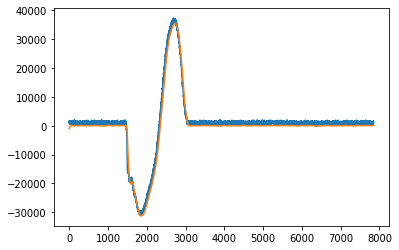

In [8]:
z = content['data']['platform'][1]['moment'][0]
f = LowPassFilter.apply(z, cutoff=20, fs=2000, order=2)
# f = medfilt(z, 9)
# f = LowPassFilter.apply(f, cutoff=20, fs=2000, order=2)
plt.plot(z)
plt.plot(f)

In [9]:
trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

force_x, force_y, force_z = get_force(content)
# swing_period_r, swing_period_l = get_swing_period(force_z)

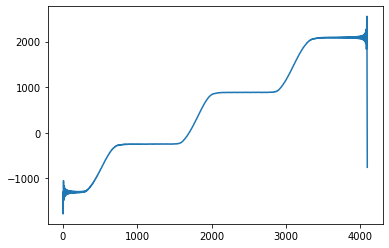

In [10]:
plt.plot(trajectory_y_r[:, 0])

In [11]:
trajectory_y_r[:, 0].shape

(4096,)

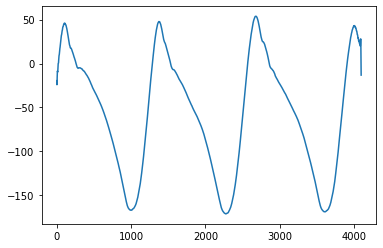

In [12]:
d = np.gradient(trajectory_y_r, axis=-1)
plt.plot(d[:, 6])
# plt.ylim([-10, 10])

In [13]:
trajectory_x_r.shape

(4096, 12)

In [14]:
sum(force_z).shape

(4096,)

In [15]:
trajectory_z_r.shape

(4096, 12)

In [16]:
filtered = LowPassFilter.apply(force_y, cutoff=20, fs=2000)

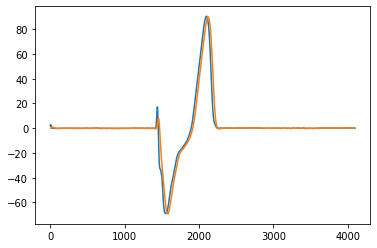

In [17]:
plt.plot(force_y[1])
plt.plot(filtered[1])

In [18]:
filtered.shape

(4, 4096)

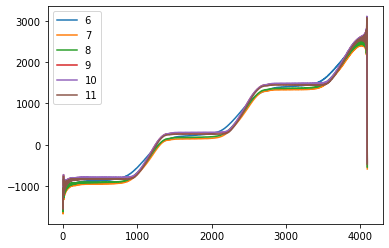

In [19]:
for i in range(6, 12):
    plt.plot(trajectory_y_r[:, i], label=f"{i}")
plt.legend()

(0.0, 10.0)

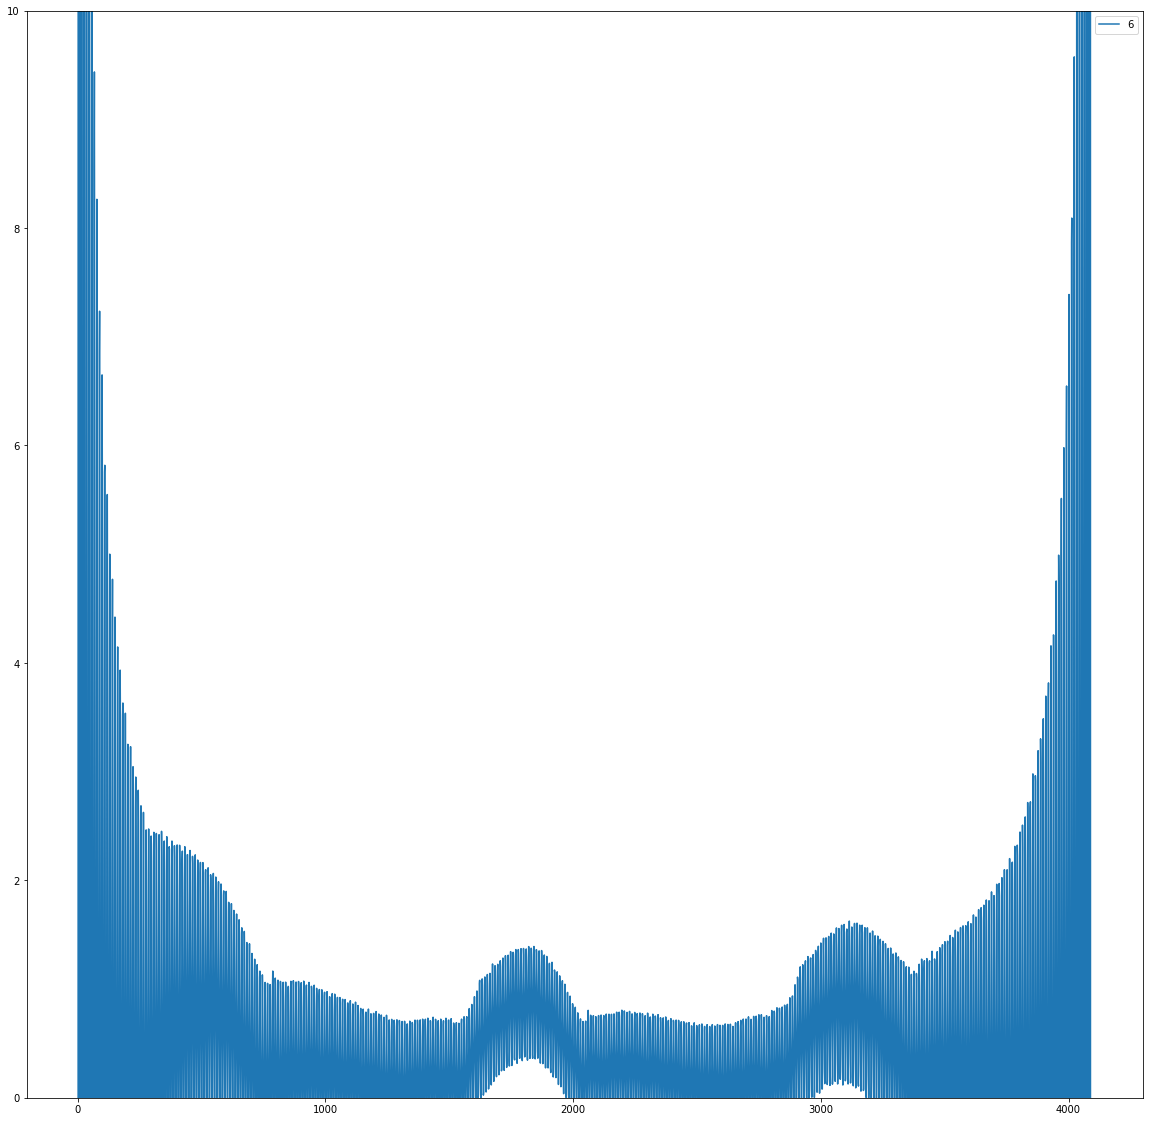

In [20]:
plt.figure(figsize=(20, 20))
trajectory_y_r = LowPassFilter.apply(trajectory_y_r, cutoff=6, fs=200)
d_trajectory_y_r = np.gradient(trajectory_y_r, axis=0)
# trajectory_y_r = LowPassFilter.apply(trajectory_y_r, cutoff=20, fs=200)
for i in range(6, 7):
    plt.plot(d_trajectory_y_r[:, i], label=f"{i}")
plt.legend()
d_trajectory_y_r.shape
plt.ylim([0,10])

(4096, 12)

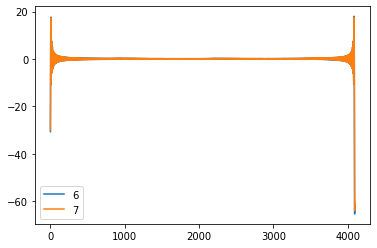

In [21]:
dd_trajectory_y_r = np.gradient(d_trajectory_y_r, axis=-1)
for i in range(6, 8):
    plt.plot(dd_trajectory_y_r[:, i], label=f"{i}")
plt.legend()
dd_trajectory_y_r.shape

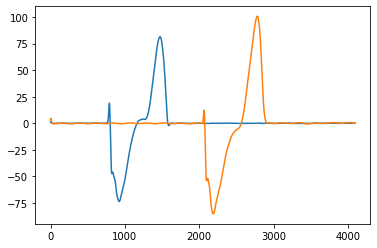

In [22]:
plt.plot(force_y[0])
# plt.plot(force_y[1])
plt.plot(force_y[2])
# plt.plot(force_y[3])

# Extract Features

In [23]:
path = os.path.join(PATH_DATASETS, PATH_DATASET_2)
subjects = os.listdir(path)

# subjects = subjects[:8]

features = pd.DataFrame()
target = pd.DataFrame()

records = []
n_samples = 0
n_bad_samples = 0

for subject in tqdm(subjects):
    velocities_path = os.path.join(path, subject, 'Raw_Data')
    velocities = os.listdir(velocities_path)

    for velocity in velocities:

        if 'V1' in velocity or 'V15' in velocity or 'V2' in velocity or 'V25' in velocity:
            continue

        files_path = os.path.join(velocities_path, velocity)
        files = os.listdir(files_path)

        for filename in files:
            try:
                content = c3d(os.path.join(files_path, filename), extract_forceplat_data=True)
                
                trajectory_x_r, trajectory_y_r, trajectory_z_r = get_trajectories(content, 'right')
                trajectory_x_l, trajectory_y_l, trajectory_z_l = get_trajectories(content, 'left')

                force_x, force_y, force_z = get_force(content)
                # moment_x, moment_y, moment_z = get_moment(content)
                swing_period_r, swing_period_l = get_swing_period(force_z)

                mask_force_z_r_1 = (force_z[0] > FORCE_THRESHOLD)
                mask_force_z_r_2 = (force_z[2] > FORCE_THRESHOLD)
                mask_force_z_l_1 = (force_z[1] > FORCE_THRESHOLD)
                mask_force_z_l_2 = (force_z[3] > FORCE_THRESHOLD)

                # ----------------------- RIGHT ------------------------

                start = np.min(np.argwhere(mask_force_z_r_1 == True))
                end = np.max(np.argwhere(mask_force_z_r_1 == True)) # + swing_period_r

                force_x_r_1 = -force_x[0][start : end]
                force_y_r_1 = force_y[0][start : end]
                force_z_r_1 = force_z[0][start : end]

                # moment_x_r_1 = moment_x[0][start : end]
                # moment_y_r_1 = moment_y[0][start : end]
                # moment_z_r_1 = moment_z[0][start : end]

                trajectory_x_r_1 = trajectory_x_l[start:end]
                trajectory_y_r_1 = trajectory_y_r[start:end]
                trajectory_z_r_1 = trajectory_z_r[start:end]

                start = np.min(np.argwhere(mask_force_z_r_2 == True))
                end = np.max(np.argwhere(mask_force_z_r_2 == True)) # + swing_period_r

                force_x_r_2 = -force_x[2][start : end]
                force_y_r_2 = force_y[2][start : end]
                force_z_r_2 = force_z[2][start : end]

                # moment_x_r_2 = moment_x[2][start : end]
                # moment_y_r_2 = -moment_y[2][start : end]
                # moment_z_r_2 = -moment_z[2][start : end]

                trajectory_x_r_2 = trajectory_x_l[start:end]
                trajectory_y_r_2 = trajectory_y_r[start:end]
                trajectory_z_r_2 = trajectory_z_r[start:end]


                # ----------------------- LEFT ------------------------

                start = np.min(np.argwhere(mask_force_z_l_1 == True))
                end = np.max(np.argwhere(mask_force_z_l_1 == True)) # + swing_period_l

                force_x_l_1 = force_x[1][start : end]
                force_y_l_1 = force_y[1][start : end]
                force_z_l_1 = force_z[1][start : end]

                # moment_x_l_1 = moment_x[1][start : end]
                # moment_y_l_1 = moment_y[1][start : end]
                # moment_z_l_1 = moment_z[1][start : end]

                trajectory_x_l_1 = trajectory_x_r[start:end]
                trajectory_y_l_1 = trajectory_y_l[start:end]
                trajectory_z_l_1 = trajectory_z_l[start:end]

                start = np.min(np.argwhere(mask_force_z_l_2 == True))
                end = np.max(np.argwhere(mask_force_z_l_2 == True)) # + swing_period_l

                force_x_l_2 = force_x[3][start : end]
                force_y_l_2 = force_y[3][start : end]
                force_z_l_2 = force_z[3][start : end]

                # moment_x_l_2 = moment_x[3][start : end]
                # moment_y_l_2 = -moment_y[3][start : end]
                # moment_z_l_2 = -moment_z[3][start : end]

                trajectory_x_l_2 = trajectory_x_r[start:end]
                trajectory_y_l_2 = trajectory_y_l[start:end]
                trajectory_z_l_2 = trajectory_z_l[start:end]


                # ... Remove all zero GRF samples
                # if np.mean(force_z_2) <= FORCE_THRESHOLD or np.mean(force_z_3) <= FORCE_THRESHOLD \
                #     or np.mean(force_z_4) <= FORCE_THRESHOLD or np.mean(force_z_5) <= FORCE_THRESHOLD:
                #     n_bad_samples = n_bad_samples + 1
                #     continue

                
                # ... Resample
                force_x_r_1 = resample(force_x_r_1, N_SAMPLES, axis=0)
                force_x_l_1 = resample(force_x_l_1, N_SAMPLES, axis=0)
                force_x_r_2 = resample(force_x_r_2, N_SAMPLES, axis=0)
                force_x_l_2 = resample(force_x_l_2, N_SAMPLES, axis=0)

                force_y_r_1 = resample(force_y_r_1, N_SAMPLES, axis=0)
                force_y_l_1 = resample(force_y_l_1, N_SAMPLES, axis=0)
                force_y_r_2 = resample(force_y_r_2, N_SAMPLES, axis=0)
                force_y_l_2 = resample(force_y_l_2, N_SAMPLES, axis=0)

                force_z_r_1 = resample(force_z_r_1, N_SAMPLES, axis=0)
                force_z_l_1 = resample(force_z_l_1, N_SAMPLES, axis=0)
                force_z_r_2 = resample(force_z_r_2, N_SAMPLES, axis=0)
                force_z_l_2 = resample(force_z_l_2, N_SAMPLES, axis=0)

                trajectory_x_r_1 = resample(trajectory_x_r_1, N_SAMPLES, axis=0)
                trajectory_x_r_2 = resample(trajectory_x_r_2, N_SAMPLES, axis=0)
                trajectory_x_l_1 = resample(trajectory_x_l_1, N_SAMPLES, axis=0)
                trajectory_x_l_2 = resample(trajectory_x_l_2, N_SAMPLES, axis=0)

                trajectory_y_r_1 = resample(trajectory_y_r_1, N_SAMPLES, axis=0)
                trajectory_y_r_2 = resample(trajectory_y_r_2, N_SAMPLES, axis=0)
                trajectory_y_l_1 = resample(trajectory_y_l_1, N_SAMPLES, axis=0)
                trajectory_y_l_2 = resample(trajectory_y_l_2, N_SAMPLES, axis=0)

                trajectory_z_r_1 = resample(trajectory_z_r_1, N_SAMPLES, axis=0)
                trajectory_z_r_2 = resample(trajectory_z_r_2, N_SAMPLES, axis=0)
                trajectory_z_l_1 = resample(trajectory_z_l_1, N_SAMPLES, axis=0)
                trajectory_z_l_2 = resample(trajectory_z_l_2, N_SAMPLES, axis=0)

                # ... Standardize
                force_x_r_1 = standardize(force_x_r_1)
                force_x_l_1 = standardize(force_x_l_1)
                force_x_r_2 = standardize(force_x_r_2)
                force_x_l_2 = standardize(force_x_l_2)

                force_y_r_1 = standardize(force_y_r_1)
                force_y_l_1 = standardize(force_y_l_1)
                force_y_r_2 = standardize(force_y_r_2)
                force_y_l_2 = standardize(force_y_l_2)

                force_z_r_1 = standardize(force_z_r_1)
                force_z_l_1 = standardize(force_z_l_1)
                force_z_r_2 = standardize(force_z_r_2)
                force_z_l_2 = standardize(force_z_l_2)

                trajectory_x_r_1 = standardize(trajectory_x_r_1)
                trajectory_x_r_2 = standardize(trajectory_x_r_2)
                trajectory_x_l_1 = standardize(trajectory_x_l_1)
                trajectory_x_l_2 = standardize(trajectory_x_l_2)

                trajectory_y_r_1 = standardize(trajectory_y_r_1)
                trajectory_y_r_2 = standardize(trajectory_y_r_2)
                trajectory_y_l_1 = standardize(trajectory_y_l_1)
                trajectory_y_l_2 = standardize(trajectory_y_l_2)

                trajectory_z_r_1 = standardize(trajectory_z_r_1)
                trajectory_z_r_2 = standardize(trajectory_z_r_2)
                trajectory_z_l_1 = standardize(trajectory_z_l_1)
                trajectory_z_l_2 = standardize(trajectory_z_l_2)

                _features_l_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_1, trajectory_y_l_1, trajectory_z_l_1], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_l_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_l_2, trajectory_y_l_2, trajectory_z_l_2], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_r_1 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_1, trajectory_y_r_1, trajectory_z_r_1], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features_r_2 = pd.DataFrame(
                    np.concatenate([trajectory_x_r_2, trajectory_y_r_2, trajectory_z_r_2], axis=1),
                    columns=[
                        '0_x', '1_x', '2_x', '3_x', '4_x', '5_x', '6_x', '7_x', '8_x', '9_x', '10_x', '11_x',
                        '0_y', '1_y', '2_y', '3_y', '4_y', '5_y', '6_y', '7_y', '8_y', '9_y', '10_y', '11_y',
                        '0_z', '1_z', '2_z', '3_z', '4_z', '5_z', '6_z', '7_z', '8_z', '9_z', '10_z', '11_z'
                    ]
                )

                _features = pd.concat([_features_l_1, _features_l_2, _features_r_1, _features_r_2], axis=0)

                _target_r_1 = pd.DataFrame(
                    np.stack([force_x_r_1, force_y_r_1, force_z_r_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_r_2 = pd.DataFrame(
                    np.stack([force_x_r_2, force_y_r_2, force_z_r_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_1 = pd.DataFrame(
                    np.stack([force_x_l_1, force_y_l_1, force_z_l_1], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target_l_2 = pd.DataFrame(
                    np.stack([force_x_l_2, force_y_l_2, force_z_l_2], axis=1),
                    columns=['fx', 'fy', 'fz']
                )

                _target = pd.concat([_target_r_1, _target_r_2, _target_l_1, _target_l_2], axis=0)

                features = pd.concat([features, _features], axis=0, ignore_index=True)
                target = pd.concat([target, _target], axis=0, ignore_index=True)

                records.append(filename)

                n_samples = n_samples + 1

            except Exception as e:
                print(f'ERROR [{subject}/{velocity}/{filename}]: {e}')
                n_bad_samples = n_bad_samples + 1
                pass

print('Number of good samples: ', n_samples)
print('Number of bad samples: ', n_bad_samples)

  6%|▋         | 1/16 [00:17<04:20, 17.34s/it]/tmp/ipykernel_10950/3022152687.py:3: RuntimeWarning: invalid value encountered in true_divide
  return (x - np.min(x, axis=0)) / (np.max(x, axis=0) - np.min(x, axis=0))
 81%|████████▏ | 13/16 [03:45<00:57, 19.09s/it]

ERROR [Participant14/V35/T6.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T5.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T7.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T2.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T3.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T9.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T8.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T1.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T4.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V35/T10.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)
ERROR [Participant14/V4/T6.c3

 88%|████████▊ | 14/16 [04:01<00:36, 18.20s/it]

ERROR [Participant14/V3/T10.c3d]: Shape of passed values is (1024, 34), indices imply (1024, 36)


100%|██████████| 16/16 [04:35<00:00, 17.23s/it]

Number of good samples:  411
Number of bad samples:  29


In [24]:
velocity

'V25'

In [25]:
features

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,2_z,3_z,4_z,5_z,6_z,7_z,8_z,9_z,10_z,11_z
0,0.965911,0.966804,0.968641,0.957733,0.967930,0.963668,0.950709,0.942268,0.845016,0.015714,...,0.240912,0.139797,0.224408,0.028835,0.041321,0.188718,0.336030,0.017856,0.188762,0.080234
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.894606,0.000000,...,0.215312,0.120150,0.173976,0.030225,0.000000,0.173654,0.312126,0.000000,0.201377,0.087379
2,0.930603,0.933694,0.936201,0.913040,0.933785,0.910271,0.893722,0.884527,0.789641,0.064027,...,0.272712,0.150560,0.266941,0.027188,0.083011,0.202955,0.357009,0.040607,0.179354,0.079931
3,0.990687,0.991691,0.991041,0.987014,0.990008,0.977179,0.981037,0.983156,0.875779,0.028301,...,0.226740,0.118318,0.182126,0.028708,0.010273,0.177520,0.315760,0.007987,0.200629,0.090481
4,0.956214,0.958748,0.958968,0.942793,0.956347,0.929247,0.926325,0.923293,0.821337,0.065575,...,0.256049,0.132056,0.228557,0.025985,0.051090,0.192458,0.337463,0.028724,0.190352,0.087525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683451,0.010287,0.009708,0.015171,0.015848,0.022825,0.022482,0.081526,0.180433,0.207867,0.362551,...,0.934133,0.845979,0.741789,0.812865,0.459488,0.005551,0.004536,0.115622,0.178261,0.131628
1683452,0.012821,0.009757,0.015605,0.015616,0.028964,0.031033,0.078127,0.172139,0.194642,0.355260,...,0.934654,0.804764,0.704758,0.784859,0.435825,0.008647,0.007234,0.109652,0.169238,0.125144
1683453,0.014225,0.009225,0.014842,0.014691,0.032362,0.036105,0.075797,0.166069,0.184704,0.347125,...,0.938738,0.776540,0.678971,0.765613,0.418853,0.010778,0.009170,0.105565,0.163032,0.120638
1683454,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090892,0.196399,0.215593,0.334224,...,1.000000,0.920733,0.803255,0.861525,0.493993,0.000000,0.000000,0.125087,0.193100,0.142829


In [26]:
target

,fx,fy,fz
0,0.055060,0.516338,0.005718
1,0.047790,0.526131,0.010913
2,0.054842,0.524685,0.019512
3,0.043373,0.537628,0.029131
4,0.045334,0.539737,0.037972
...,...,...,...
1683451,0.237191,0.537415,0.009001
1683452,0.235066,0.535102,0.006044
1683453,0.232829,0.532976,0.005062
1683454,0.239666,0.530110,0.000411


In [27]:
path = '../../Dataset/Processed/data2_f72_t3_n1_high_vel.joblib'
data = {
    'X': features,
    'y': target
}
dump(data, path)

['../../Dataset/Processed/data2_f72_t3_n1_high_vel.joblib']

# Generating Train Test Sets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load, dump
from sklearn.model_selection import train_test_split

N_SAMPLES = 1024
N_CHANNELS = 36

path = '../../Dataset/Processed/data2_f72_t3_n1_high_vel.joblib'
data = load(path)
features = data['X']
target = data['y']

# path1 = '../../Dataset/Processed/data2_f72_t3_n1_p1.joblib'
# path2 = '../../Dataset/Processed/data2_f72_t3_n1_p2.joblib'

# data1 = load(path1)
# data2 = load(path2)

# features1 = data1['X']
# features2 = data2['X']

# target1 = data1['y']
# target2 = data2['y']

# print(features1.shape)
# print(features2.shape)

# print(target1.shape)
# print(target2.shape)

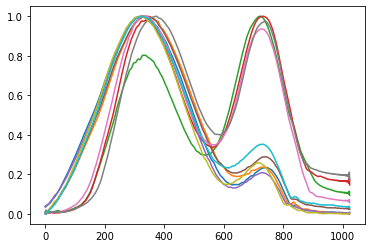

In [42]:
# x = features['11_z'].to_numpy().reshape(-1, N_SAMPLES)
# for i in range(1120, 1130):
#     plt.plot(x[i, :])

In [30]:
# features = pd.concat([features1, features2])
# target = pd.concat([target1, target2])

# print(features.shape)
# print(target.shape)

(4014080, 36)
(4014080, 3)


In [43]:
X = features.to_numpy().reshape(-1, N_SAMPLES, N_CHANNELS)
y = target.to_numpy().reshape(-1, N_SAMPLES, 3)

print(X.shape)
print(y.shape)

(1644, 1024, 36)
(1644, 1024, 3)


In [44]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(1315, 1024, 36)
(329, 1024, 36)
(1315, 1024, 3)
(329, 1024, 3)


In [45]:
path = '../../Dataset/Processed/data2_f72_t3_n1_high_vel_combined.joblib'
data = {
    'train_X': train_X,
    'test_X': test_X,
    'train_y': train_y,
    'test_y': test_y
}
dump(data, path)

['../../Dataset/Processed/data2_f72_t3_n1_high_vel_combined.joblib']

<h1 align="center">Verification</h1>

In [34]:
# path = '../../Dataset/Processed/data2_f15_t3_n1.joblib'
# data = load(path)

# features = data['X']
# target = data['y']

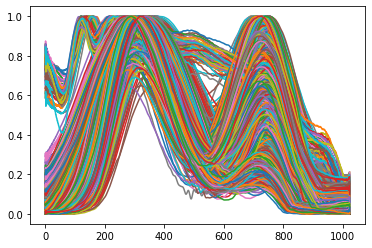

In [16]:
x = features['11_z'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

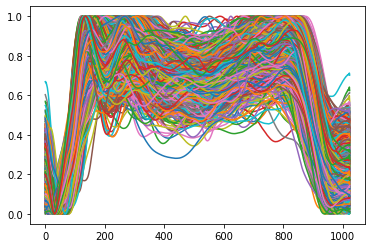

In [4]:
y = target['fx'].to_numpy().reshape(-1, N_SAMPLES)
for i in range(y.shape[0]):
    plt.plot(y[i, :])

In [37]:
i

3919

In [38]:
features.shape

(4014080, 36)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(3)

X = pca.fit_transform(features)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
X.shape

In [ ]:
x = X[:, 2].reshape(-1, N_SAMPLES)
for i in range(x.shape[0]):
    plt.plot(x[i, :])

In [ ]:
features